## Version 03 -> Pred RUL

In [9]:
!pip install texttable
from platform import python_version
print(python_version())

3.8.5


In [10]:
# importing required libraries
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint as pp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ARDRegression, SGDRegressor
from texttable import Texttable
import math
from sklearn.metrics import r2_score

# getting the battery data
# bs_all = [
#     'B0005', 'B0006', 'B0007', 'B0018', 'B0025', 'B0026', 'B0027', 'B0028', 'B0029', 'B0030', 'B0031', 'B0032', 
#     'B0042', 'B0043', 'B0044', 'B0045', 'B0046', 
#     'B0047', 'B0048'
# ]
bs_all = [
    'B0005', 'B0006', 'B0007', 'B0018'
]
ds = {}
for b in bs_all:
    ds[b] = loadmat(f'DATA/{b}.mat')
    
types = {}
times = {}
ambient_temperatures = {}
datas = {}

for b in bs_all:
    x = ds[b][b]["cycle"][0][0][0]
    ambient_temperatures[b] = x['ambient_temperature']
    types[b] = x['type']
    times[b] = x['time']
    datas[b] = x['data']

# clubbing all the compatible batteries together
# Batteries are compatible if they were recorded under similar conditions
# And their data size match up
bs_compt = {}

for b in bs_all:
    sz = 0
    for j in range(datas[b].size):
        if types[b][j] == 'discharge':
            sz += 1
    if bs_compt.get(sz):
        bs_compt[sz].append(b)
    else: 
        bs_compt[sz] = [ b ]
pp(bs_compt)
BSSS = bs_compt

{132: ['B0018'], 168: ['B0005', 'B0006', 'B0007']}


In [11]:
## CRITICAL TIME POINTS FOR A CYCLE
## We will only these critical points for furthur training

## TEMPERATURE_MEASURED
## => Time at highest temperature

## VOLTAGE_MEASURED
## => Time at lowest Voltage

## VOLTAGE_LOAD
## => First time it drops below 1 volt after 1500 time

def getTemperatureMeasuredCritical(tm, time):
    high = 0
    critical = 0
    for i in range(len(tm)):
        if (tm[i] > high):
            high = tm[i]
            critical = time[i]
    return critical

def getVoltageMeasuredCritical(vm, time):
    low = 1e9
    critical = 0
    for i in range(len(vm)):
        if (vm[i] < low):
            low = vm[i]
            critical = time[i]
    return critical

def getVoltageLoadCritical(vl, time):
    for i in range(len(vl)):
        if (time[i] > 1500 and vl[i] < 1):
            return time[i]
    return -1

## MODEL
* Considering 1 Cycle for RUL estimation

## Features
* [CP1, CP2, CP3, Capacity] -> RUL

## Remaining Useful Life
* n = number of cycles above threshold
* RUL of Battery after (cycle x) = (1 - (x / n)) * 100

In [12]:
## X: Features
## y: RUL
## x: no. of cycles to merge
def merge(X, y, x):
    XX = []
    yy = []
    
    sz = len(X)
    for i in range(sz - x + 1):
        curr = []
        for j in range(x):
            for a in X[i + j]:
                curr.append(a)
        XX.append(curr)
#         val = 0
#         for j in range(x):
#             val += y[i + j]
#         val /= x
        yy.append(y[i + x - 1])
        
    return XX, yy

In [13]:
## Data Structure
    # Cycles[battery][param][cycle]
    # Cycles[battery][Capacity][cycle]

Cycles = {}
params = ['Temperature_measured', 'Voltage_measured', 'Voltage_load', 'Time']

rmses = []

for bs_cmpt in bs_compt:
    rmses.append([])

# iterate over the merge hyper parameter
for xx in range(1, 10):

    results = Texttable()
    results.add_row(['Compatible Batteries', 'Cycles', 'MAE', 'RMSE', 'R2 Score' ])
    
    loc = 0
    
    # iterate over all the battery sets
    for bs_cmpt in bs_compt:
        # getting data for a given set

        # y contains RUL after current cycle
        # model will train for y
        y = []

        bs = bs_compt[bs_cmpt]
        for b in bs:
            Cycles[b] = {}
            for param in params:
                Cycles[b][param] = []
                for j in range(datas[b].size):
                    if types[b][j] == 'discharge':
                        Cycles[b][param].append(datas[b][j][param][0][0][0])

            cap = []
            for j in range(datas[b].size):
                if types[b][j] == 'discharge':
                    cap.append(datas[b][j]['Capacity'][0][0][0][0])
            Cycles[b]['Capacity'] = np.array(cap)
            Cycles[b]['count'] = len(Cycles[b][params[0]])

            effective_cycle_count = 0
            for x in Cycles[b]['Capacity']:
                if (x < 1.4):
                    break
                effective_cycle_count += 1

            for i in range(len(Cycles[b]['Capacity'])):
                if (i < effective_cycle_count):
                    y.append((1 - ((i + 1) / effective_cycle_count)) * 100)
                else:
                    y.append(0)

        # preparing data for regression model
        temperature_measured = []
        voltage_measured = []
        voltage_load = []
        capacity = []

        for b in bs:        
            for c in Cycles[b]['Capacity']:
                capacity.append(c)
            for i in range(Cycles[b]['count']):
                temperature_measured.append(getTemperatureMeasuredCritical(Cycles[b]['Temperature_measured'][i], Cycles[b]['Time'][i]))
                voltage_measured.append(getVoltageMeasuredCritical(Cycles[b]['Voltage_measured'][i], Cycles[b]['Time'][i]))
                voltage_load.append(getVoltageLoadCritical(Cycles[b]['Voltage_load'][i], Cycles[b]['Time'][i]))

        # creating the model
        X = []
        for i in range(len(temperature_measured)):
            X.append(np.array([temperature_measured[i], voltage_measured[i], voltage_load[i], capacity[i]]))
    #     X.append(np.array(capacity))
        X = np.array(X)
        y = np.array(y)
        
        # merge cycles
        X, y = merge(X, y, xx)

        # creating train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

        # fitting the model
        regressor = LinearRegression()
        regressor.fit(X_train, y_train)

        # test
        y_pred = regressor.predict(X_test)

        # model evaluation
        diff = 0
        total = 0
        rmse = 0
        for i in range(len(y_test)):
            diff += abs(y_test[i] - y_pred[i])
            rmse += ((y_test[i] - y_pred[i]) * (y_test[i] - y_pred[i]))
            total += y_test[i]
        diff /= len(y_test)
        total /= len(y_test)
        rmse = math.sqrt(rmse / len(y_test))
    #     accuracy = ((total - diff) / total) * 100
        accuracy = r2_score(y_test, y_pred)

        # Adding evaluation to result array to print in a table
        results.add_row([ str(bs), str(Cycles[bs[0]]['count']), diff, rmse, accuracy ])
        
        rmses[loc].append(rmse)
        loc += 1

    # printing results
#     print(f'Evaluation: Clubbing Compatible Batteries for cycle param: {xx}\n{results.draw()}')

In [14]:
# print(rmses)

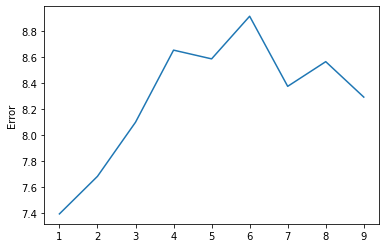

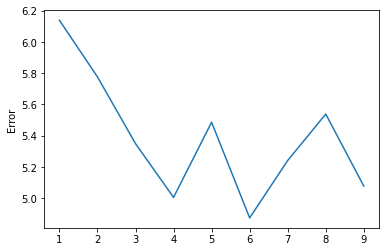

In [15]:
for rm in rmses:
    plt.plot(range(1, len(rm) + 1), rm)
    plt.ylabel("Error")
    plt.show()

In [16]:
def removeFromGroup(x):
    loc = 0
    y = {}
    for a in x:
        for b in x[a]:
            y[loc] = [ b ]
            loc += 1
    return y

In [17]:
!pip install scikit-elm
!pip install --upgrade pyswarm
!pip install dask
!pip install fsspec>=0.3.3

Requirement already up-to-date: pyswarm in /home/yash/anaconda3/lib/python3.8/site-packages (0.6)


In [25]:
from pyswarm import pso

from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm   

## Data Structure
    # Cycles[battery][param][cycle]
    # Cycles[battery][Capacity][cycle]

ranges_l = [0, 20, 50, 70]
ranges_r = [21, 51, 71, 91]

# iterate over range
for iii in tqdm(range(len(ranges_l))):
    
    ## example values 0, 20, 50, 70
    xxxx = ranges_l[iii]

     

    Cycles = {}
    params = ['Temperature_measured', 'Voltage_measured', 'Voltage_load', 'Time']

    # remove batteries from group
    bs_compt = BSSS
    bs_compt = removeFromGroup(bs_compt)


    final_results = []
    final_results_train = []
    
    # iterate over seed
    for seed in tqdm(range(25)):

        rmses = []
        rmses_train = []

        for bs_cmpt in bs_compt:
            rmses.append([bs_compt[bs_cmpt][0]])
            rmses_train.append([bs_compt[bs_cmpt][0]])


        hyper_params = []


        ######################################## CHANGE THISSSSSS ###############################################
        # example values (1, 21) (21, 51) (51, 71) (71, 91)
        # iterate over the merge hyper parameter
        for xx in range(ranges_l[iii] + 1, ranges_r[iii]):

            results = Texttable()
            results.add_row([ 'Compatible Batteries', 'Cycles', 'MAE', 'RMSE', 'R2 Score' ])

            loc = 0

            # iterate over all the battery sets
            for bs_cmpt in bs_compt:
                # getting data for a given set

                # y contains RUL after current cycle
                # model will train for y
                y = []

                bs = bs_compt[bs_cmpt]
                for b in bs:
                    Cycles[b] = {}
                    for param in params:
                        Cycles[b][param] = []
                        for j in range(datas[b].size):
                            if types[b][j] == 'discharge':
                                Cycles[b][param].append(datas[b][j][param][0][0][0])

                    cap = []
                    for j in range(datas[b].size):
                        if types[b][j] == 'discharge':
                            cap.append(datas[b][j]['Capacity'][0][0][0][0])
                    Cycles[b]['Capacity'] = np.array(cap)
                    Cycles[b]['count'] = len(Cycles[b][params[0]])

                    effective_cycle_count = 0
                    for x in Cycles[b]['Capacity']:
                        if (x < 1.4):
                            break
                        effective_cycle_count += 1

                    for i in range(len(Cycles[b]['Capacity'])):
                        if (i < effective_cycle_count):
                            y.append((1 - ((i + 1) / effective_cycle_count)) * 100)
                        else:
                            y.append(0)

                # preparing data for regression model
                temperature_measured = []
                voltage_measured = []
                voltage_load = []
                capacity = []

                for b in bs:        
                    for c in Cycles[b]['Capacity']:
                        capacity.append(c)
                    for i in range(Cycles[b]['count']):
                        temperature_measured.append(getTemperatureMeasuredCritical(Cycles[b]['Temperature_measured'][i], Cycles[b]['Time'][i]))
                        voltage_measured.append(getVoltageMeasuredCritical(Cycles[b]['Voltage_measured'][i], Cycles[b]['Time'][i]))
                        voltage_load.append(getVoltageLoadCritical(Cycles[b]['Voltage_load'][i], Cycles[b]['Time'][i]))

                # creating the model
                X = []
                for i in range(len(temperature_measured)):
                    X.append(np.array([temperature_measured[i], voltage_measured[i], voltage_load[i], capacity[i]]))
            #     X.append(np.array(capacity))
                X = np.array(X)
                y = np.array(y)

                # merge cycles
                X, y = merge(X, y, xx)

                # creating train test split
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = seed)

                ############## ------------------ MODEL ------------------- ####################

#                 ## [1. linear reg] ###
#                 regressor = Ridge(alpha=1000000)
#                 regressor.fit(X_train, y_train)
#                 y_pred = regressor.predict(X_test)
#                 y_pred_train = regressor.predict(X_train)



#                 ## [2. ARDRegresssor] ###
#                 regressor = ARDRegression()
#                 regressor.fit(X_train, y_train)
#                 y_pred = regressor.predict(X_test)
#                 y_pred_train = regressor.predict(X_train)


#                 ## [3. Bayes Model] ###
#                 regressor = BayesianRidge()
#                 regressor.fit(X_train, y_train)
#                 y_pred = regressor.predict(X_test)
#                 y_pred_train = regressor.predict(X_train)


    #     #         ## ELM Regressor with pso ###
#                 from skelm import ELMRegressor

    #             def objective(aaa):
    #                 estimator = ELMRegressor(alpha = aaa[0], 
    #                                      n_neurons = aaa[1], 
    #                                      ufunc='relu', 
    #                                      include_original_features = False)

    #                 estimator.fit(X_train, y_train)
    #                 y_pred = estimator.predict(X_test)

    #                 rmse = 0
    #                 for i in range(len(y_test)):
    #                     rmse += ((y_test[i] - y_pred[i]) * (y_test[i] - y_pred[i]))
    #                 rmse = math.sqrt(rmse / len(y_test))

    #                 return rmse

    #             # bounds for hyper param
    #             lb = [1, 10]
    #             ub = [1e6, 1000]

    #             # optimizing
    #             xopt, fopt = pso(objective, lb, ub)

    #     #         hyper_params.append(xopt)

                  ## [4. ELM] ######
#                 estimator = ELMRegressor(alpha = 1e6, 
#                                          n_neurons = 800, 
#                                          ufunc='relu', 
#                                          include_original_features = False)

#                 estimator.fit(X_train, y_train)
#                 y_pred = estimator.predict(X_test)
#                 y_pred_train = estimator.predict(X_train)


#                 ### [5. Decision Tree] ###
#                 from sklearn import tree
#                 regressor = tree.DecisionTreeRegressor()
#                 regressor.fit(X_train, y_train)
#                 y_pred = regressor.predict(X_test)
#                 y_pred_train = regressor.predict(X_train)

                ### [6. Random Forest Regressor] ### (BEST)
                regressor = RandomForestRegressor(max_depth =10, random_state= 0)
                regressor.fit(X_train, y_train)
                y_pred = regressor.predict(X_test)
                y_pred_train = regressor.predict(X_train)

                ############# ----------------- MODEL -------------------- #####################

                # model evaluation
                diff = 0
                total = 0
                rmse = 0
                for i in range(len(y_test)):
                    diff += abs(y_test[i] - y_pred[i])
                    rmse += ((y_test[i] - y_pred[i]) * (y_test[i] - y_pred[i]))
                    total += y_test[i]
                diff /= len(y_test)
                total /= len(y_test)
                rmse = math.sqrt(rmse / len(y_test)) / 100
                accuracy2 = ((total - diff) / total) * 100
                accuracy = r2_score(y_test, y_pred)

                # Adding evaluation to result array to print in a table
        #         results.add_row([ str(bs), str(Cycles[bs[0]]['count']), diff, rmse, accuracy, accuracy2 ])

                rmses[loc].append(rmse)

                #### adding rmses of the train
                rmse_train = 0
                for i in range(len(y_train)):
                    rmse_train += ((y_train[i] - y_pred_train[i]) * (y_train[i] - y_pred_train[i]))
                rmse_train = math.sqrt(rmse_train / len(y_train)) / 100
                rmses_train[loc].append(rmse_train)
                loc += 1

        final_results.append(rmses)
        final_results_train.append(rmses_train)


    ## --- STORING RESULTS TO THE FILE
    # %matplotlib
    from statistics import stdev, mode

    mns = { 
        'B0005': [],
        'B0006': [],
        'B0007': [],
        'B0018': []
    }
    mns_train = { 
        'B0005': [],
        'B0006': [],
        'B0007': [],
        'B0018': []
    }
    cycles = { 
        'B0005': [],
        'B0006': [],
        'B0007': [],
        'B0018': []
    }
    cycles_train = { 
        'B0005': [],
        'B0006': [],
        'B0007': [],
        'B0018': []
    }

    fo = open(f"/home/yash/Documents/RUL/RESULTS_25_ITR(STD, AVG)/Random Forest Reg/{ranges_l[iii] + 1}-{ranges_r[iii] - 1}/result.txt", "w")


    stddevs_rmses = []
    avgs_rmses = []

    for ii in range(len(final_results)):
        rmses = final_results[ii]
        rmses_train = final_results_train[ii]
        for i in range(len(rmses)):
            rm = rmses[i]
            rm_train = rmses_train[i]

            mn = 100000
            mn_train = 100000
            loc, loc_train = -1, -1
            for i in range(1, len(rm)):
                if (mn > rm[i]):
                    mn = rm[i]
                    loc = i

                if (mn_train > rm_train[i]):
                    mn_train = rm_train[i]
                    loc_train = i

            fo.write(f"{rm[0]}\n")
            fo.write("Minima Test: {:.16f}, Param (x): {}\n".format(mn, loc + xxxx))
            fo.write("Minima Train: {:.16f}, Param (x): {}\n".format(mn_train, loc_train + xxxx))
            fo.write("\n")

            mns[rm[0]].append(mn)
            mns_train[rm[0]].append(mn_train)

            cycles[rm[0]].append(loc + xxxx)
            cycles_train[rm[0]].append(loc_train + xxxx)

    #         fig, ax = plt.subplots()
    #         ax.plot(range(1 + xxxx, len(rm) + xxxx), rm[1:], "-b", label="test set")
    #         ax.plot(range(1 + xxxx, len(rm) + xxxx), rm_train[1:], "-r", label="train set")
    #         plt.legend(loc="upper right")
    #         plt.ylabel(rm[0])
    #         plt.show()

    fo.write("-----------------------------------------------------------------------------------\n")
    fo.write("\n")

    for battery in mns:
        fo.write(f"Battery: {battery} StdDevRMSE: {stdev(mns[battery])}\n")
        fo.write(f"Battery: {battery} AvgRMSE: {sum(mns[battery]) / len(mns[battery])}\n")
        fo.write(f"Battery: {battery} ModeCycleParam: {mode(cycles[battery])}\n")
        fo.write("\n")

    # print(f"Standard Dev RMSE: {stddevs_rmses}")
    # print(f"Average RMSE: {avgs_rmses}")

    # Close opend file
    fo.close()



 44%|████▍     | 11/25 [07:48<09:55, 42.55s/it]<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100
<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100
<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100

 48%|████▊     | 12/25 [08:31<09:13, 42.61s/it]<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100
<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100

 68%|██████▊   | 17/25 [12:02<05:39, 42.40s/it]<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100

<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100

 84%|████████▍ | 21/25 [14:52<02:49, 42.36s/it]<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100
<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100

 92%|█████████▏| 23/25 [16:18<01:25, 42.61s/it]<ipython-input-25-7e1404cd7536>:209: RuntimeWarning: divide by zero encountered in double_scalars
  accuracy2 = ((total - diff) / total) * 100

100%|██████████| 4/4 [1:13:55<00:00, 1108.81s/it]


In [25]:
# %matplotlib
from statistics import stdev, mode

mns = { 
    'B0005': [],
    'B0006': [],
    'B0007': [],
    'B0018': []
}
mns_train = { 
    'B0005': [],
    'B0006': [],
    'B0007': [],
    'B0018': []
}
cycles = { 
    'B0005': [],
    'B0006': [],
    'B0007': [],
    'B0018': []
}
cycles_train = { 
    'B0005': [],
    'B0006': [],
    'B0007': [],
    'B0018': []
}

fo = open("/home/yash/Documents/RUL/RESULTS_25_ITR(STD, AVG)/Random Forest Reg/21-50/result.txt", "w")


stddevs_rmses = []
avgs_rmses = []

for ii in range(len(final_results)):
    rmses = final_results[ii]
    rmses_train = final_results_train[ii]
    for i in range(len(rmses)):
        rm = rmses[i]
        rm_train = rmses_train[i]

        mn = 100000
        mn_train = 100000
        loc, loc_train = -1, -1
        for i in range(1, len(rm)):
            if (mn > rm[i]):
                mn = rm[i]
                loc = i

            if (mn_train > rm_train[i]):
                mn_train = rm_train[i]
                loc_train = i

        fo.write(f"{rm[0]}\n")
        fo.write("Minima Test: {:.16f}, Param (x): {}\n".format(mn, loc + xxxx))
        fo.write("Minima Train: {:.16f}, Param (x): {}\n".format(mn_train, loc_train + xxxx))
        fo.write("\n")
        
        mns[rm[0]].append(mn)
        mns_train[rm[0]].append(mn_train)

        cycles[rm[0]].append(loc + xxxx)
        cycles_train[rm[0]].append(loc_train + xxxx)
        
#         fig, ax = plt.subplots()
#         ax.plot(range(1 + xxxx, len(rm) + xxxx), rm[1:], "-b", label="test set")
#         ax.plot(range(1 + xxxx, len(rm) + xxxx), rm_train[1:], "-r", label="train set")
#         plt.legend(loc="upper right")
#         plt.ylabel(rm[0])
#         plt.show()

fo.write("-----------------------------------------------------------------------------------\n")
fo.write("\n")

for battery in mns:
    fo.write(f"Battery: {battery} StdDevRMSE: {stdev(mns[battery])}\n")
    fo.write(f"Battery: {battery} AvgRMSE: {sum(mns[battery]) / len(mns[battery])}\n")
    fo.write(f"Battery: {battery} ModeCycleParam: {mode(cycles[battery])}\n")
    fo.write("\n")

# print(f"Standard Dev RMSE: {stddevs_rmses}")
# print(f"Average RMSE: {avgs_rmses}")

# Close opend file
fo.close()
